In [1]:
import pandas as pd
import numpy as np
import time
import re
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import glob
from multiprocessing import Process

In [53]:
from analytics import *

# <h1 style='padding:2%;font-family:times'> 1- Introdução </h1>

<p align='justify' style='padding:2%;font-family:times'> Máquina de Turing (MT) é um modelo teórico que descreve o comportamento de uma unidade de processamento (CPU - Computer Processing Unit), incluindo as limitações de CPU. Dessa forma, se não é possível executar um algoritmo com esse modelo, também não é possível executar em uma máquina física com uma CPU <a href='./report_tm.ipynb#ref1'>(MICHEL SIPSER, [s.d.])</a>.  Essa conclusão é muito importante para a ciência da computação porque permite mensurar quais problemas são possíveis de resolver utilizando um computador e quais não. </p>

# <h1 style='padding:2%;font-family:times'> 2 - Projeto e Implementação do Algoritmo </h1>

<p align='justify' style='padding:2%;font-family:times'>O algoritmo proposto é a continuação do algoritmo proposto para o Autômato de Pilha Não Determinístico. Foram feitas algumas mudanças nele, como a substituição da pilha por uma fita e da pilha de processos por uma fila de processos. A fila de processos, identificada por <i>threads</i>, serve para gerenciar o não determinismo, onde cada <i>thread</i> (caminho diferente) armazena uma configuração instantânea da máquina. A ideia é adicionar todos os novos caminhos encontrados na fila para serem processados pela função de transição. Esse gerenciamento de *threads* é feito na função de transição extendida. </p>

# <h1 style='padding:2%;font-family:times'> 3 - Metodologia </h1>

<p align='justify' style='padding:2%;font-family:times'> O desenvolvimento seguiu ao estilo *kanban*, onde insere-se uma *task* (tarefa) a ser feita em uma agenda, retirada de uma lista de tarefas identificadas previamente. Testes são realizados a cada fez que uma tarefa é finaliza. Para realizar estes testes, alguns casos de testes foram definidos, onde são importados diretamente por meio de um arquivo, com extensão <i>tm</i>. A estrutura desse arquivo segue a mesma estrutra da entrada na especificação do projeto, um exemplo deles é o <a href='./data/def1.tm'><i>def1.tm</i></a>. As funções utilizadas para testar o algoritmo estão no arquivo <a href='./analytics.py'><i>analytics.py</i></a> e a definição do algoritmo da Máquina de Turing está no arquivo <a href='./tm.py'><i>tm.py</i></a>. Cada função ou método implementado também foi testado separadamente antes se serem submetidos a um teste completo do algoritmo da MT. A identificação de erros foi feita através dos testes com os arquivos <i>tm</i>. Cada nova versão do projeto é enviada para um repositório online, através do controlador de versões Git.</p>

# <h1 style='padding:2%;font-family:times'> 4 -Resultados e Conclusões </h1>

<p align='justify' style='padding:2%;font-family:times'> Segue o modelo com os métodos para o algoritmo de simulação de MT proposto abaixo.</p>

In [ ]:
class TM(): #Turing Machine

    def __init__(self):
        pass

    def auto_run(self):
        
        E = input().split(" ") #1° line: list of states
        alphabet = input().split(" ") #2° line: alphabet
        tape_alphabet = input().split(" ") #3° line: the alphabet of the data tape
        self.l_limiter = input() #4° line: data tape left limiter
        self.white = input() #5° line: the white character
        n = int(input()) #n transactions

        #----- set states ------
        alphabet.append("*") #make sure the alphabet have the empty character
        
        #initialize the data tape
        tape_alphabet = [self.l_limiter] + tape_alphabet #add left limiter
        tape_alphabet.append(self.white) #make sure the data tape have white character after left limiter

        iteractions = []
        for i in range(n):
            iteractions.append(input())

        self.mt_graph = self._build_graph(E, alphabet, tape_alphabet, iteractions)

        self.init_state = str(input())

        self.final_states = str(input()).split(" ")

        words = input().split(" ")

        for word in words:
            print(self.extended_delta(list(word)))

    def _build_graph(self, E, alphabet, tape_alphabet, iteractions):
        """Initialize the graph which describes the rule of transactions.

        @E: (List) list of states
        @alphabet: (List) the set of characters of alphabet (Σ)
        @tape_alphabet: (List) the set of characters of alphabet (Γ)
        Σ is subset of Γ
        """
        mt_graph = dict()

        for e in E: #initialize the graph
            for c in alphabet: 
                mt_graph[(e, c)] = []

            for c in tape_alphabet: 
                mt_graph[(e, c)] = []

        for it in iteractions: #to each n iteration, receive <a, b, c, d, e>:
            """
            a: 0 = start state, b: 1 = character on tape, c: 2 = destination state, 
            d: 3 = character to be writed on tape, e: 4 = direction (E = left, D = right, I = feft before right)
            """
            s = it.split(" ")
            mt_graph[(s[0], s[1])].append((s[2], s[3], s[4])) #(a, b)_<p> -> [(c, d, e)_1, (c, d, e)_2, ..., (c, d, e)_n]

        return mt_graph

    def direction(self, d, i):
        
        if d == "D":
            return i + 1
        
        if d == "E":
            return i - 1

        return i

    def get(self, tape, i, default):
        """ Return a value, if i is in range of index. Return default if not.
        @l: (List)
        @i: (int) Position
        @default: (Object) Default value, can be string, int, float etc.
        """
        len_l = len(tape)

        if len_l <= i:
            #complete the tape
            for j in range(i-len_l+1):
                tape.append(default)
        
        return tape[i]
            
    def extended_delta(self, tape):
        tape = list(tape) #make sure the tape is a list

        if not self.l_limiter in tape: #Make sure the tape is with correct shape
            tape = [self.l_limiter] + tape

        threads = [(self.init_state, 1, tape)] # (current state, heah position, tape data)
        
        while threads:
            c_ste, i, tape_t = threads.pop() #tape_t: tape at thread t. Each thread have a tape
            
            transactions = self.mt_graph[(c_ste, self.get(tape_t, i, self.white))]  #Transactions we have to state c_ste receiving word_i
            
            if c_ste in self.final_states and len(transactions) == 0: #if current state is a final state and new transactions to this thread doesn't exists
                return "S" #is accepted

            self.delta(i, transactions, tape_t, threads) #threads is changed by reference
            
        return "N"

    def delta(self, i, transactions, tape_t, threads):
        """Process transactions. Return (bool).
        Return True only if the current thread stop on final state and have not new transactions to do
        @i: (int) head position
        @transactions: (List) transactions to current thread
        @tape_t: (List) data tape to current thread
        @threads: (List) remain threads to be processed
        """
        for c, d, e in transactions: #c: new state, d: character to be writed on tape_t[i], e: direction
            i_ = self.direction(e,i) #change the head position based on direction definition
            tape_t_ = tape_t.copy() #make sure not change the current tape_t to avoid conflits
            tape_t_[i] = d #write the character e at i position of new tape_t
            threads.append((c, i_, tape_t_)) #insert on threads to be processed

    def setup(self, definition):
        """Method to test the algorithm
        @Definition: (Dataframe)
        """
        E = definition[0].split(" ") #1° line: list of states
        alphabet = definition[1].split(" ") #2° line: alphabet
        tape_alphabet = definition[2].split(" ") #3° line: the alphabet of the data tape
        self.l_limiter = definition[3] #4° line: data tape left limiter
        self.white = definition[4] #5° line: the white character
        n = int(definition[5]) #n transactions

        #----- set states ------
        alphabet.append("*") #make sure the alphabet have the empty character
        
        #initialize the data tape
        tape_alphabet = [self.l_limiter] + tape_alphabet #add left limiter
        tape_alphabet.append(self.white) #make sure the data tape have white character after left limiter

        iteractions = []
        for i in range(6, n+6, 1):
            iteractions.append(definition[i])

        self.mt_graph = self._build_graph(E, alphabet, tape_alphabet, iteractions)

        self.init_state = str(definition[n+6])

        self.final_states = str(definition[n+7]).split(" ")

<p style='padding:2%;font-family:times'> Foram separados 5 Máquinas de Turing para realizar o estudo empírico do tempo de execução. A implementação do algoritmo que executa os casos de testes pode ser vista no arquivo <a href='./multiprocess_tests.py'> <i>multiprocess_tests.py</i></a>, onde foi implementado em multiprocessos de <i>multithreads</i> porque o algoritmo demora muito tempo para alguns casos, daí, inseriu-se esse gerenciador que limita o tempo de execução, para cada palavra de entrada na máquina.</p>

#### <h3 style='padding:2%;font-family:times'> Visualizar Formas de curva

<p style='padding:2%;font-family:times'> A visualização das formas de curvas é importante para escolher um modelo que se adequa melhor ao comportamento dessas} curvas. </p>

In [24]:
#Build dataset with all definitions together
dataset = []
for uri in glob.glob("./data/*.csv"):
    d_df = pd.read_csv(uri)
    d_d = d_from_file(uri.replace(".csv",".tm"))

    d_df.loc[:,"states"] = len(d_d[0].split(" ")) #add quantity of states
    d_df.loc[:,"n"] = int(d_d[5])

    dataset.append(d_df)

dataset = pd.concat(dataset)

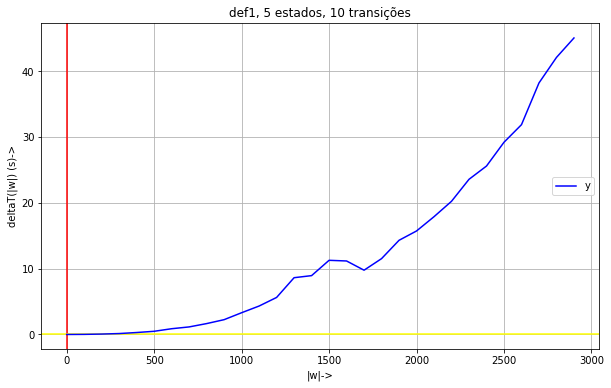

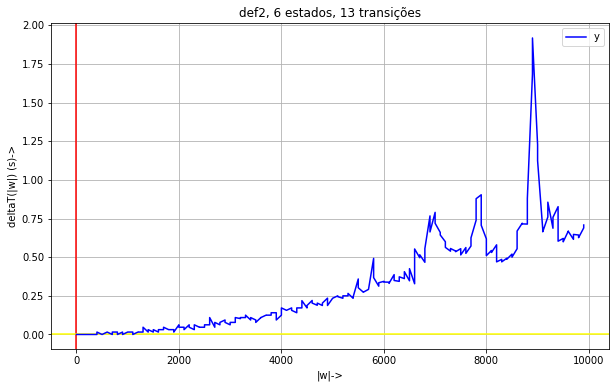

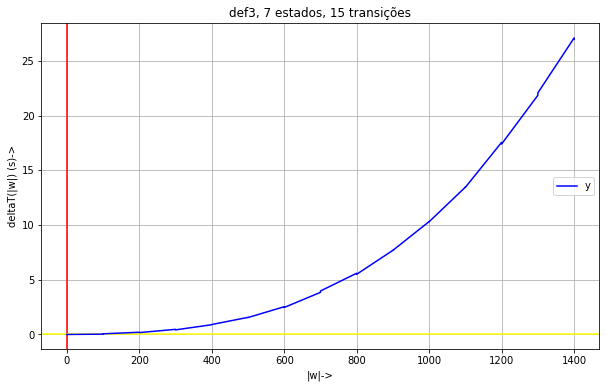

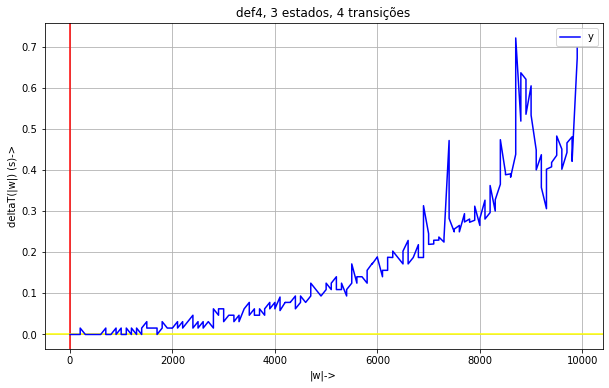

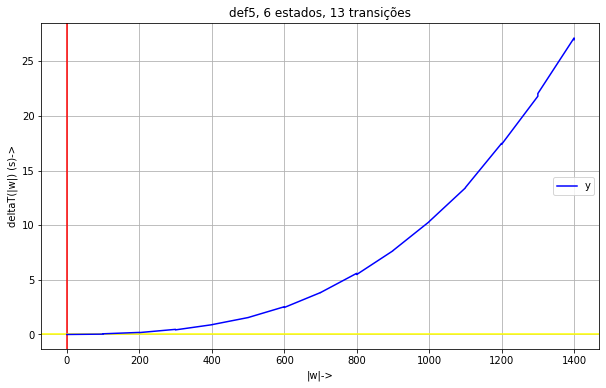

In [27]:
dataset_g = dataset.groupby(by='name')
for name in dataset_g.indices.keys():
    data_name = dataset_g.get_group(name)
    row_0 = data_name.iloc[0]
    plot(data_name.len_w, data_name.deltaT, title=name+", "+str(row_0['states'])+" estados, "+str(row_0['n'])+" transições", w=10, h=6)

#### <h3 style='padding:2%;font-family:times'> Regressão </h3>

<p align='justify' style='padding:2%;font-family:times'>É possível inferir que o comportamento das curvas se aproximam de um modelo exponencial. Por isso, é feito um ajuste de curva exponencial sobre os dados obtidos nos casos de teste.</p>

In [28]:
def func(x, a, b, c):
    return a*np.exp(b*x-c)

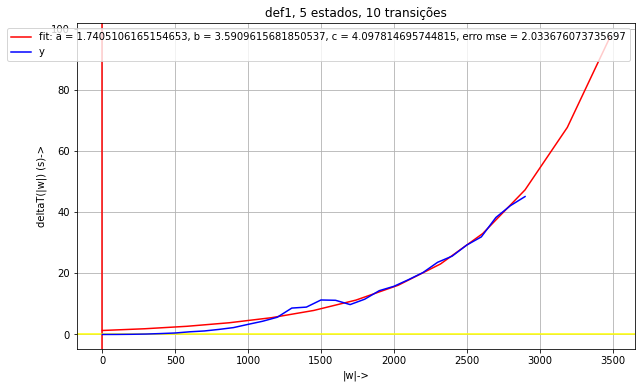

c:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


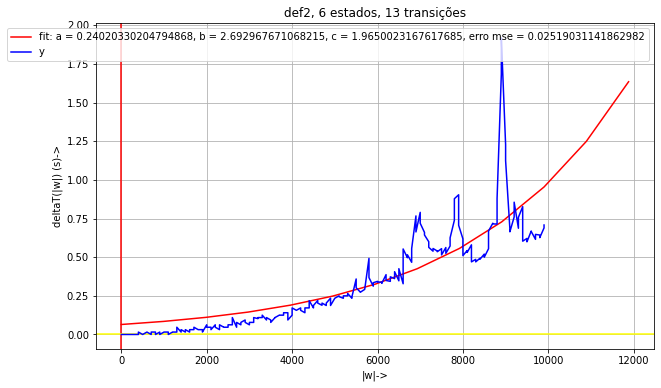

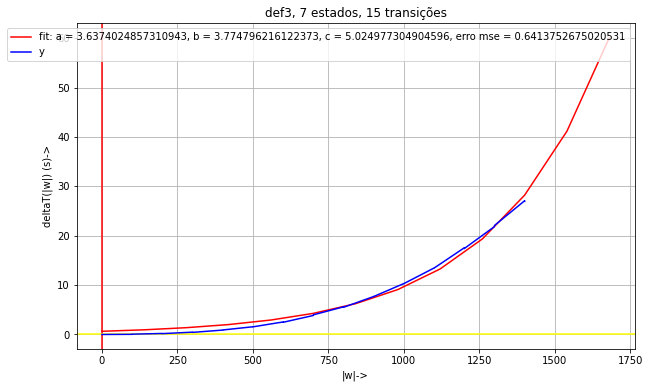

c:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


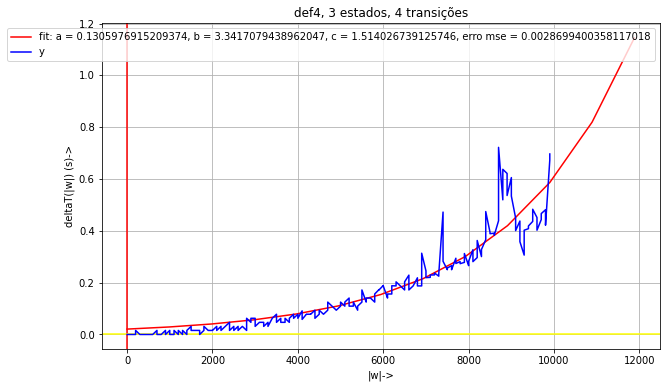

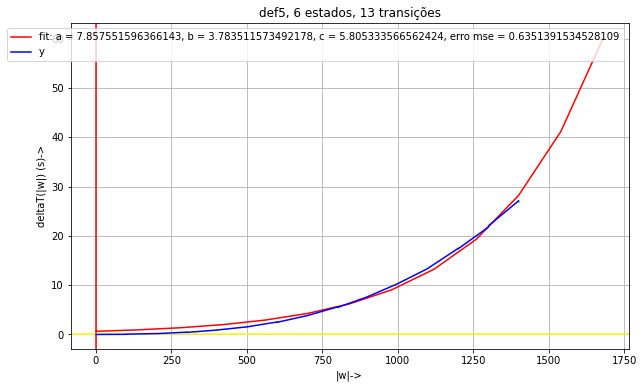

In [52]:
model_tests = {}

dataset_max = dataset_g.max()

for name in dataset_g.indices.keys():
    data_name = dataset_g.get_group(name)
    dataset_name_max = dataset_max.loc[name]
    row_0 = data_name.iloc[0]

    popt, pcov = curve_fit(func, data_name.len_w/dataset_name_max['len_w'], data_name.deltaT/dataset_name_max['deltaT'])
    model_tests[name] = {"a": popt[0], "b": popt[1], "c": popt[2]} #parameters found to curve fitted

    #inference to calc error
    delta_pred = func(data_name.len_w/dataset_name_max['len_w'], *popt)*dataset_name_max['deltaT']
    mse_error = mean_squared_error(data_name.deltaT, delta_pred)

    #To plot the result
    x_pred = np.arange(0, data_name.len_w.max() / dataset_name_max['len_w'] + 0.3, 0.1)
    y_pred = func(x_pred, *popt)*dataset_name_max['deltaT']
    plot_compare(data_name.len_w, data_name.deltaT, x_pred*data_name.len_w.max(), y_pred, popt, mse_error, name+", "+str(row_0['states'])+" estados, "+str(row_0['n'])+" transições")

<p style='padding:2%;font-family:times'> Nos gráficos acima, o eixo y é o a quantidade de segundos gastos para processar uma palavra de tamanho |w|.</p>

# Referências

<div id="ref1">MICHEL SIPSER. Introduction to the Theory of Computation. 3. ed. [s.l.] GENGAGE Learning, [s.d.]. <div>